In [1]:
import numpy as np
import matplotlib.pyplot as plt     
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import scipy.io as sio
from scipy.optimize import curve_fit

from cil.io import NEXUSDataReader

import os

from utils import cnr_spatial, K_edge_sub

**In this script we reproduce the main figures created for the accompanying paper, using the reconstructed lizard head data.**

Note: Here we use .nxs files of the reconstructed datasets, produced using the additional scripts provided (`Lizard_Head_120s_60Proj_FDK_TVTGV.ipnb`). You will need to run this script first in order to create the necessary reconstructed datasets used in creating the figures.

First read in the .nxs data files using the `NEXUSDataReader`.

In [2]:
reader = NEXUSDataReader(file_name = "HyperspectralData/Lizard_120s_60Proj_FDK.nxs")
lizard_fdk_recon = reader.load_data()

reader = NEXUSDataReader(file_name = "HyperspectralData/1000_iters_alpha_0.002_beta_0.25.nxs")
lizard_tv_tgv_recon = reader.load_data()

# Read Energy-Channel conversion
tmp_energy_channels = sio.loadmat("MatlabData/Energy_axis.mat")
ekeV = tmp_energy_channels['E_axis']
ekeV_crop = ekeV[0][59:159]

In the paper, we show all values in terms of attenuation value.  
Currently our reconstructed datasets are measured in terms of 'optical density'. We convert to attenuation by dividing by the voxel size. For the powder phantom, the voxel size is 137 $\mu$m.

In [3]:
#%% Convert data from Optical density to attenuation

vox_size_um = 137

for i in range(lizard_tv_tgv_recon.shape[0]):
    lizard_tv_tgv_recon.as_array()[i] = lizard_tv_tgv_recon.as_array()[i]/vox_size_um
    lizard_fdk_recon.as_array()[i] = lizard_fdk_recon.as_array()[i]/vox_size_um

## Figure 4

Comparison of the FDK and TV-TGV reconstructed datasets, with qualitative and quantitative analysis.

### Figure 4a

Reconstructed slices for the two reconstructed datasets, shown in two different image planes.

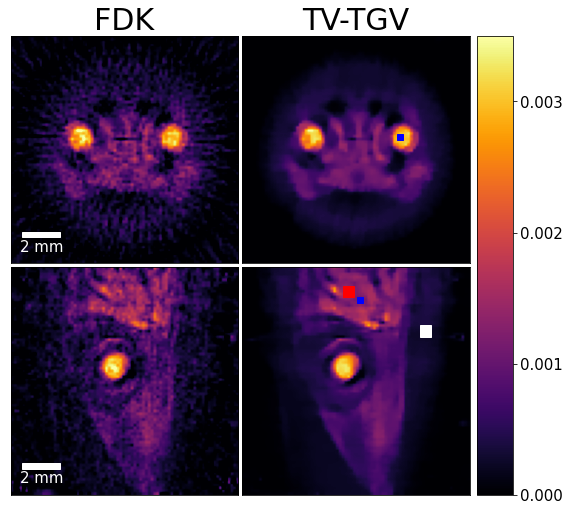

In [4]:
from mpl_toolkits.axes_grid1 import AxesGrid

recons = [lizard_fdk_recon.as_array()[60,35,:,:], lizard_tv_tgv_recon.as_array()[60,35,:,:],
         lizard_fdk_recon.as_array()[60,:,:,25], lizard_tv_tgv_recon.as_array()[60,:,:,25]]

labels_text = ["FDK", "TV-TGV"]

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(9, 10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_size = 0.5,
                cbar_pad=0.1
                )

fontprops = fm.FontProperties(size=15)


k = 0

for ax in grid:
    scalebar = AnchoredSizeBar(ax.transData,
                           13.33, '2 mm', 'lower left', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                          fontproperties=fontprops)
    
    im = ax.imshow(recons[k], cmap="inferno", vmin = 0.0, vmax = 0.0035)   
    
    if k==0:
        ax.set_title(labels_text[0],fontsize=30)
        ax.add_artist(scalebar)
    if k==1:
        ax.set_title(labels_text[1],fontsize=30)  
        rect1 = patches.Rectangle((54,34),2,2,linewidth=1,edgecolor='b',facecolor='b')
        ax.add_patch(rect1)
    if k==2:
        ax.add_artist(scalebar)
    if k==3:
        rect = patches.Rectangle((40,10),2,2,linewidth=1,edgecolor='b',facecolor='b')
        ax.add_patch(rect)
        rect2 = patches.Rectangle((35,6),4,4,linewidth=1,edgecolor='r',facecolor='r')
        ax.add_patch(rect2)
        rect3 = patches.Rectangle((62,20),4,4,linewidth=1,edgecolor='w',facecolor='w')
        ax.add_patch(rect3)
    
    ax.set_xticks([])
    ax.set_yticks([])
    k+=1

cbar = grid.cbar_axes[0].colorbar(im,ticks=[0.0,0.0010,0.0020,0.0030])

### Figure 4b

Spectral plots for two ROIs in the lizard head, corresponding to the Lens of the eye, and a section of the Jaw muscle.

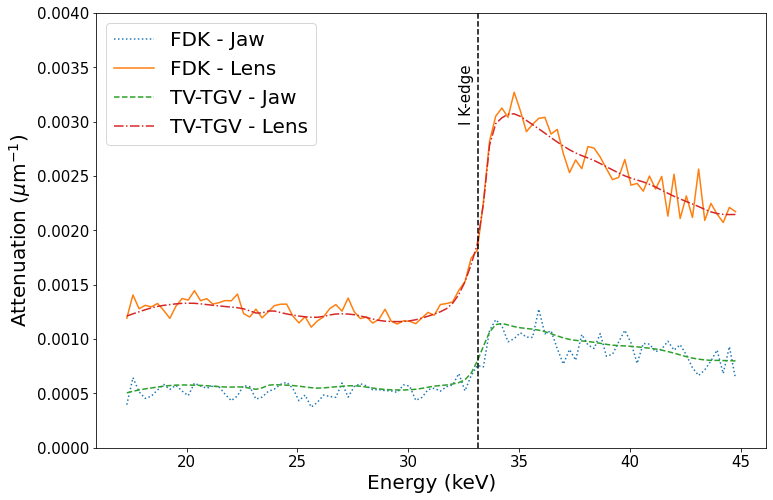

In [5]:
# Average over the ROIs for each soft tissue region, for each reconstructed dataset

# Lens
avg_y_x_FDK_lens = lizard_fdk_recon.as_array()[:,35,36:38,54:56]
avg_ROI_FDK_lens = np.mean(np.mean(avg_y_x_FDK_lens,axis=1),axis=1)
avg_y_x_TGV_lens = lizard_tv_tgv_recon.as_array()[:,35,36:38,54:56]
avg_ROI_TGV_lens = np.mean(np.mean(avg_y_x_TGV_lens,axis=1),axis=1)

# Jaw
avg_y_x_FDK_jaw = lizard_fdk_recon.as_array()[:,10:12,40:42,25]
avg_ROI_FDK_jaw = np.mean(np.mean(avg_y_x_FDK_jaw,axis=1),axis=1)
avg_y_x_TGV_jaw = lizard_tv_tgv_recon.as_array()[:,10:12,40:42,25]
avg_ROI_TGV_jaw = np.mean(np.mean(avg_y_x_TGV_jaw,axis=1),axis=1)

# Plot result
plt.figure(figsize=(12,8))
plt.plot(ekeV_crop,avg_ROI_FDK_jaw,label='FDK - Jaw',linestyle=':')
plt.plot(ekeV_crop,avg_ROI_FDK_lens,label='FDK - Lens',linestyle='-')
plt.plot(ekeV_crop,avg_ROI_TGV_jaw,label='TV-TGV - Jaw',linestyle='--')
plt.plot(ekeV_crop,avg_ROI_TGV_lens,label='TV-TGV - Lens',linestyle='-.')

plt.axvline(x=33.169, color = 'black', linestyle = "--")
plt.text(32.3, 0.003, "I K-edge", rotation=90, fontsize=15, color = "black")
plt.ylim(0.0,0.004)
plt.xlabel('Energy (keV)',fontsize=20), plt.ylabel('Attenuation ($\mu$m$^{-1}$)',fontsize=20)
plt.legend(fontsize=20, loc='upper left')

In [6]:
# Values for Jaw ROI
# FDK
avg_y_x_FDK_jaw = lizard_fdk_recon.as_array()[:,6:11,35:40,25]
avg_ROI_FDK_jaw = np.mean(np.mean(avg_y_x_FDK_jaw,axis=1),axis=1)
std_ROI_FDK_jaw = np.std(np.std(avg_y_x_FDK_jaw,axis=1),axis=1)
mean_val_FDK_jaw = np.mean(std_ROI_FDK_jaw)
std_ROI_FDK_jaw = np.ones(100)*mean_val_FDK_jaw

# TV-TGV
avg_y_x_TGV_jaw = lizard_tv_tgv_recon.as_array()[:,6:11,35:40,25]
avg_ROI_TGV_jaw = np.mean(np.mean(avg_y_x_TGV_jaw,axis=1),axis=1)
std_ROI_TGV_jaw = np.std(np.std(avg_y_x_TGV_jaw,axis=1),axis=1)
mean_val_TGV_jaw = np.mean(std_ROI_TGV_jaw)
std_ROI_TGV_jaw = np.ones(100)*mean_val_TGV_jaw

# Values for background ROI
# FDK
avg_y_x_FDK_bg = lizard_fdk_recon.as_array()[:,20:25,62:67,25]
avg_ROI_FDK_bg = np.mean(np.mean(avg_y_x_FDK_bg,axis=1),axis=1)
std_ROI_FDK_bg = np.std(np.std(avg_y_x_FDK_bg,axis=1),axis=1)
mean_val_FDK_bg = np.mean(std_ROI_FDK_bg)
std_ROI_FDK_bg = np.ones(100)*mean_val_FDK_bg

# TV-TGV
avg_y_x_TGV_bg = lizard_tv_tgv_recon.as_array()[:,20:25,62:67,25]
avg_ROI_TGV_bg = np.mean(np.mean(avg_y_x_TGV_bg,axis=1),axis=1)
std_ROI_TGV_bg = np.std(np.std(avg_y_x_TGV_bg,axis=1),axis=1)
mean_val_TGV_bg = np.mean(std_ROI_TGV_bg)
std_ROI_TGV_bg = np.ones(100)*mean_val_TGV_bg

In [7]:
# Calculate CNR values using cnr_spatial function
cnr_FDK = cnr_spatial(avg_ROI_FDK_jaw,std_ROI_FDK_jaw,avg_ROI_FDK_bg,std_ROI_FDK_bg)
cnr_TGV = cnr_spatial(avg_ROI_TGV_jaw,std_ROI_TGV_jaw,avg_ROI_TGV_bg,std_ROI_TGV_bg)

Calculation Complete!
Calculation Complete!


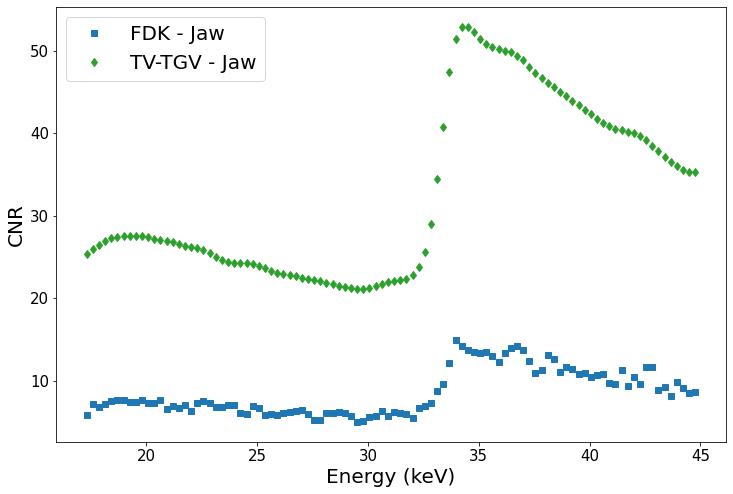

In [8]:
# Plot results for each reconstructed dataset

plt.figure(figsize=(12,8))
plt.plot(ekeV_crop,cnr_FDK,'s',markersize=6,label = 'FDK - Jaw',color='C0')
plt.plot(ekeV_crop,cnr_TGV,'d',markersize=6,label = 'TV-TGV - Jaw',color='C2')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Energy (keV)',fontsize=20)
plt.ylabel('CNR',fontsize=20)
plt.legend(fontsize=20, loc='upper left')

## Figure 5

Figure 5a was produced using the step size spectral analysis, such as the example given in Fig 5b. The TomViz software was used to produce the images, so here we only show the method by which Fig. 5b was created.

### Figure 5b

Example of step size analysis across the spectral range for an ROI in the jaw adductor muscle for both the FDK and TV-TGV reconstructed datasets. 
For this we require the energy-channel conversion parameters. These can be calculated from the `Energy_axis.mat` file directly, but for ease we have included the linear conversion values below, such that:

Energy (keV) = Channel number x 0.2774 + 0.6619

We must also adjust for the fact we started our reduced channel subset from channel 60 [59-159], therefore we must shift the calculated channel positions accordingly.

Finally we must know the channel number corresponding to the known position of the K-edge, in this case for iodine (33.169 keV).

In [9]:
# Define limits of linear regions either side of absorption edge
lin_reg = [21,30,35,44]
lin_reg = [float(x) for x in lin_reg]

def func_lin(x, a, b):
    return (a * x) + b

# Define channel equivalents
# Linear conversion intercept and gradient
gradient = 0.2774
intercept = 0.6619
start_channel = 59

# Define position of known K-edges, convert to channel
edge = 33.169
edge_channel = int(((edge - intercept)/gradient) - start_channel)

lower1_channel = int(((lin_reg[0]-intercept)/gradient)-start_channel)
lower2_channel = int(((lin_reg[1]-intercept)/gradient)-start_channel)
upper1_channel = int(((lin_reg[2]-intercept)/gradient)-start_channel)
upper2_channel = int(((lin_reg[3]-intercept)/gradient)-start_channel)
regions = [lower1_channel,lower2_channel,upper1_channel,upper2_channel]

In [10]:
# Analysis of Jaw

# Calculate average value across ROI
# TV TGV
avg_y_x_TGV_jaw = lizard_tv_tgv_recon.as_array()[:,10,40,24:27]
avg_ROI_TGV_jaw = np.mean(avg_y_x_TGV_jaw,axis=1)
PDHG_pixel = avg_ROI_TGV_jaw

# FDK
avg_y_x_180_jaw = lizard_fdk_recon.as_array()[:,10,40,24:27]
avg_ROI_180_jaw = np.mean(avg_y_x_180_jaw,axis=1)
FDK_pixel = avg_ROI_180_jaw

# Calculate data interpolation between defined channel regions
# TV-TGV
[popt1,pcov1] = curve_fit(func_lin, ekeV_crop[regions[0]:regions[1]], PDHG_pixel[regions[0]:regions[1]])
[popt2,pcov2] = curve_fit(func_lin, ekeV_crop[regions[2]:regions[3]], PDHG_pixel[regions[2]:regions[3]])

# FDK
[popt3,pcov3] = curve_fit(func_lin, ekeV_crop[regions[0]:regions[1]], FDK_pixel[regions[0]:regions[1]])
[popt4,pcov4] = curve_fit(func_lin, ekeV_crop[regions[2]:regions[3]], FDK_pixel[regions[2]:regions[3]])


# Calculate distance between known edge position and linear regions either side
shift1 = edge_channel - regions[1]
shift2 = regions[2] - edge_channel

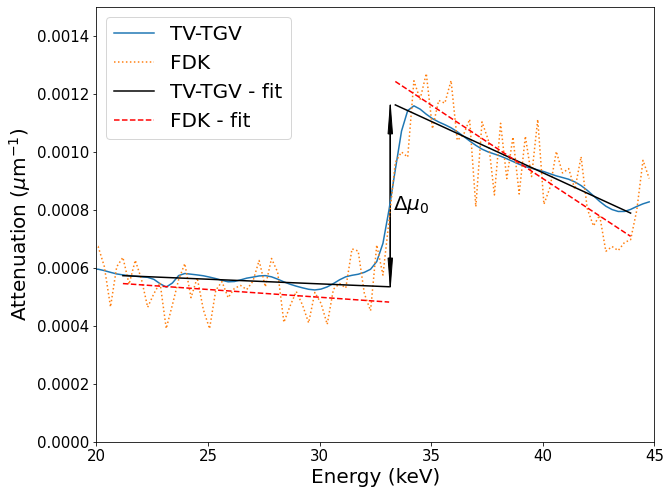

In [11]:
# Plot both FDK and TV-TGV fits

# Plot full FDK and TV-TGV data over spectral range
plt.figure(figsize=(10,8))
plt.plot(ekeV_crop,avg_ROI_TGV_jaw, label='TV-TGV') 
plt.plot(ekeV_crop,avg_ROI_180_jaw, label='FDK',ls=':') 

# Calculate linear fits and plot fits on top
# TV-TGV fit
lower_att = func_lin(ekeV_crop[regions[1]+shift1],*popt1)
upper_att = func_lin(ekeV_crop[regions[2]-shift2],*popt2)
plt.plot(ekeV_crop[regions[0]:regions[1]+shift1],
         func_lin(ekeV_crop[regions[0]:regions[1]+shift1],*popt1),'k-', label='TV-TGV - fit')
plt.plot(ekeV_crop[regions[2]-shift2:regions[3]],
         func_lin(ekeV_crop[regions[2]-shift2:regions[3]],*popt2),'k-')

# FDK fit
lower_att2 = func_lin(ekeV_crop[regions[1]+shift1],*popt3)
upper_att2 = func_lin(ekeV_crop[regions[2]-shift2],*popt4)
plt.plot(ekeV_crop[regions[0]:regions[1]+shift1],
         func_lin(ekeV_crop[regions[0]:regions[1]+shift1],*popt3),'r--', label='FDK - fit')
plt.plot(ekeV_crop[regions[2]-shift2:regions[3]],
         func_lin(ekeV_crop[regions[2]-shift2:regions[3]],*popt4),'r--')

# Add vertical arrow indicating how step size is measured
plt.arrow(33.169,lower_att,0,upper_att-lower_att,head_width=0.2,head_length=0.0001,length_includes_head='True',ls= "-",color='black')
plt.arrow(33.169,upper_att,0,lower_att-upper_att,head_width=0.2,head_length=0.0001,length_includes_head='True',ls= "-",color='black')
plt.text(33.3, 0.0008, r'$\Delta\mu_0$', fontsize=20, color = "black")
plt.xlim(20.0,45.0),plt.ylim(0.0,0.0015)
plt.xlabel('Energy (keV)',fontsize=20), plt.ylabel('Attenuation ($\mu$m$^{-1}$)',fontsize=20)
plt.legend(fontsize=20, loc='upper left')

## Figure 6

Figure 6 hyperspectral results were produced using the K-edge subtraction method, with final images created using the TomViz software. Here we simply show the process by which the K-edge subtraction method was applied to the data, before transferring over to TomViz.
The `K_edge_sub` function in the `utils.py` file describes how the function works in more detail, but simply put, the function isolates the data corresponding to the absorption edge, such that we can segment out the chemical element causing the spectral marker, in this case iodine.  
Two parameters known as `Width` and `Separation` are needed to define isolation region.  

We can also store the resulting data in two parts: 
- The isolated region belonging to the spectral marker
- The remaining material which should contain none of the chemical element identified.

In [12]:
# Apply K-edge subtraction for each known K-edge in the sample (in this case one - Iodine at 33.169 keV)
# Recommended Width = 5, Sep = 2

KEdgeSubtracted_FDK = []
KEdgeRemaining_FDK = []
KEdgeSubtracted_TVTGV = []
KEdgeRemaining_TVTGV = []
width = 5
sep = 2

# FDK
print('FDK\n')
results_fdk = K_edge_sub(lizard_fdk_recon, edge_channel, width, sep)
KEdgeSubtracted_FDK.append(results_fdk[0])
KEdgeRemaining_FDK.append(results_fdk[1])

# TV-TGV
print('\nTV-TGV\n')
results_tvtgv = K_edge_sub(lizard_tv_tgv_recon, edge_channel, width, sep)
KEdgeSubtracted_TVTGV.append(results_tvtgv[0])
KEdgeRemaining_TVTGV.append(results_tvtgv[1])

FDK

Edge at channel:  58
Integrated channel ranges [63 64 65] [51 52 53]
Calculation Complete!

TV-TGV

Edge at channel:  58
Integrated channel ranges [63 64 65] [51 52 53]
Calculation Complete!
